# Análise de dados: Anúncios de redes sociais

Este é um projeto de machine learning para análise de dados de usuários que efetuaram ou não uma compra, os dados foram disponibilizados na plataforma [Kaggle](https://www.kaggle.com/datasets/dragonheir/logistic-regression).

Não estão definidos no dataset o caso proposto e o problema a ser solucionado, então baseados nos dados serem de compras efetuadas ou não por usuários e arquivo de dados ser nomeado como "anúncios de redes sociais", será adotada a seguinte interpretação: *O arquivo Social_Network_Ads.csv contém dados de usuários de uma rede social que tiveram alguma interação com um anúncio e foram incentivados ou não a efetuar uma compra, sendo assim o objetivo do desenvolvimento do modelo será em prever quais clientes estimulados pelo(s) anúncio(s) realizará ou não uma compra.*

## Demanda da análise

- Analisar a correlação dos dados dos usuários.
- Gerar um modelo preditivo de compra ou não por um usuário.
- Simular novas entradas de dados e previsões.

## Tópicos da análise

1. Análise das medidas estatísticas dos dados
2. Distribuição dos dados entre as variáveis independentes (features) e dependente (target)
3. Correlação entre as variáveis
4. Criação do modelo de regressão linear múltipla
   1. Separação dos dados de treino e teste 
   2. Treinamento do modelo
   3. Predições do modelo com dados de teste
   4. Resíduo, diferença entre dados de teste e dados previstos
   5. Métricas de performance
   6. Previsões com novos dados


## Importação de pacotes


In [312]:
# Importação de pacotes e definição de parâmetros globais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, r2_score, classification_report,
    mean_squared_error,
    mean_squared_log_error,
    mean_absolute_error,
    mean_absolute_percentage_error)
from tabulate import tabulate

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')


## Carregamento dos dados


In [313]:
# Efetuando limpeza de memória antes do carregamento de dados
gc.collect()

# Caminho do arquivo
path = 'dados/Social_Network_Ads.csv'

# Criando um dataframe a partir do arquivo no diretório dados
df = pd.read_csv(path, encoding='utf-8', sep=',')


## Detalhes do dataframe


In [314]:
# Informações do dataset como nome das colunas, contagem de linhas,
# tipo de dados e memória utilizada

df.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 36.9 KB


In [315]:
# Amostra de dados do dataframe

df.sample(10)

,User ID,Gender,Age,EstimatedSalary,Purchased
113,15773447,Male,37,55000,0
379,15749381,Female,58,23000,1
177,15594577,Male,25,22000,0
333,15587177,Male,40,65000,0
394,15757632,Female,39,59000,0
343,15629739,Female,47,51000,1
154,15605327,Male,40,47000,0
136,15668504,Female,20,82000,0
53,15671655,Female,35,23000,0
6,15598044,Female,27,84000,0


In [316]:
# Renomeando as colunas

print("\nNomes originais das colunas\n\n", df.columns.to_list())

df.rename(columns={'User ID': 'id_usuario',
                   'Gender': 'genero',
                   'Age': 'idade',
                   'EstimatedSalary': 'salario_estimado',
                   'Purchased': 'comprado'},
        inplace=True)

print("\nNovos nomes das colunas\n\n", df.columns.to_list())



Nomes originais das colunas

 ['User ID', 'Gender', 'Age', 'EstimatedSalary', 'Purchased']

Novos nomes das colunas

 ['id_usuario', 'genero', 'idade', 'salario_estimado', 'comprado']


In [317]:
# Quantidade de linhas e colunas

df.shape


(400, 5)

## Removendo colunas que não serão utilizadas


In [318]:
df = df.drop(columns=['id_usuario'])


## Verificando e tratando se necessário os valores duplicados


In [319]:
# Identificando a quantidade de valores duplicados (True)

df.duplicated(keep='first').value_counts()


False    380
True      20
dtype: int64

In [320]:
# Listando os valores duplicados e definindo a ação a ser tomada

display(df[df.duplicated()])


print('''Embora exista uma quantidade considerável de dados duplicados se 
comparado a toda a amostra de dados, cada registro era identificado pela 
coluna 'id_usuario' ('User ID') que é exclusivo/único de cada usuário, as 
colunas 'genero', 'idade', 'salario_estimado' e 'comprado', sendo que a 
coluna 'salario_estimado', como o próprio nome diz, é uma estimativa de 
ganho do usuário, logo estes dados apontados como duplicados serão mantidos 
no dataframe.''')


,genero,idade,salario_estimado,comprado
74,Male,32,18000,0
94,Female,29,83000,0
186,Female,20,82000,0
192,Male,29,43000,0
231,Male,39,42000,0
236,Male,40,57000,0
256,Female,41,72000,0
257,Male,40,57000,0
312,Female,38,50000,0
322,Male,41,52000,0


Embora exista uma quantidade considerável de dados duplicados se 
comparado a toda a amostra de dados, cada registro era identificado pela 
coluna 'id_usuario' ('User ID') que é exclusivo/único de cada usuário, as 
colunas 'genero', 'idade', 'salario_estimado' e 'comprado', sendo que a 
coluna 'salario_estimado', como o próprio nome diz, é uma estimativa de 
ganho do usuário, logo estes dados apontados como duplicados serão mantidos 
no dataframe.


## Verificando e tratando se necessário os valores únicos

In [321]:
# Verificando a quantidade de valores únicos

df.nunique()


genero                2
idade                43
salario_estimado    117
comprado              2
dtype: int64

In [322]:
# Verificando a quantidade dos valores únicos de colunas específicas

genero_qtde = pd.DataFrame(df['genero'].value_counts().sort_index())
genero_qtde = genero_qtde.T
print(genero_qtde)

idade_qtde = pd.DataFrame(df['idade'].value_counts().sort_index())
idade_qtde = idade_qtde.T
print('\n', idade_qtde)

comprado_qtde = pd.DataFrame(df['comprado'].value_counts().sort_index())
comprado_qtde = comprado_qtde.T
print('\n', comprado_qtde)


        Female  Male
genero     204   196

        18  19  20  21  22  23  24  25  26  27  ...  51  52  53  54  55  56  \
idade   5   7   7   4   5   6   9   6  16  13  ...   3   6   5   4   3   3   

       57  58  59  60  
idade   5   6   7   7  

[1 rows x 43 columns]

             0    1
comprado  257  143


In [323]:
# Transformando os valores da categoria 'genero' em categorias distintas e 
# traduzindo os valores da categoria 'genero'

arr_genero = OneHotEncoder().fit_transform(
    df['genero'].values.reshape(-1, 1)).toarray()
df_genero = pd.DataFrame(arr_genero)
df_genero.rename(columns={0: 'feminino', 1: 'masculino'}, inplace=True)
df = pd.concat([df, df_genero], axis=1)
df['genero'].replace({'Male': 'Masculino', 'Female': 'Feminino'}, inplace=True)
df.head(10)


,genero,idade,salario_estimado,comprado,feminino,masculino
0,Masculino,19,19000,0,0.0,1.0
1,Masculino,35,20000,0,0.0,1.0
2,Feminino,26,43000,0,1.0,0.0
3,Feminino,27,57000,0,1.0,0.0
4,Masculino,19,76000,0,0.0,1.0
5,Masculino,27,58000,0,0.0,1.0
6,Feminino,27,84000,0,1.0,0.0
7,Feminino,32,150000,1,1.0,0.0
8,Masculino,25,33000,0,0.0,1.0
9,Feminino,35,65000,0,1.0,0.0


## Verificando e tratando se necessário os tipos de valores


In [324]:
# Identificando os tipos de dados das colunas

df.dtypes


genero               object
idade                 int64
salario_estimado      int64
comprado              int64
feminino            float64
masculino           float64
dtype: object

## Verificando e tratando se necessário os valores nulos


In [325]:
# Identificando a quantidade de valores nulos

df.isnull().sum()


genero              0
idade               0
salario_estimado    0
comprado            0
feminino            0
masculino           0
dtype: int64

## Amostra de dados do dataframe


In [326]:
df.sample(10)


,genero,idade,salario_estimado,comprado,feminino,masculino
307,Feminino,47,113000,1,1.0,0.0
133,Feminino,21,68000,0,1.0,0.0
245,Feminino,51,146000,1,1.0,0.0
330,Masculino,38,51000,0,0.0,1.0
136,Feminino,20,82000,0,1.0,0.0
234,Feminino,38,112000,0,1.0,0.0
46,Masculino,25,79000,0,0.0,1.0
14,Masculino,18,82000,0,0.0,1.0
394,Feminino,39,59000,0,1.0,0.0
377,Feminino,42,53000,0,1.0,0.0


## 1. Análise das medidas estatísticas dos dados


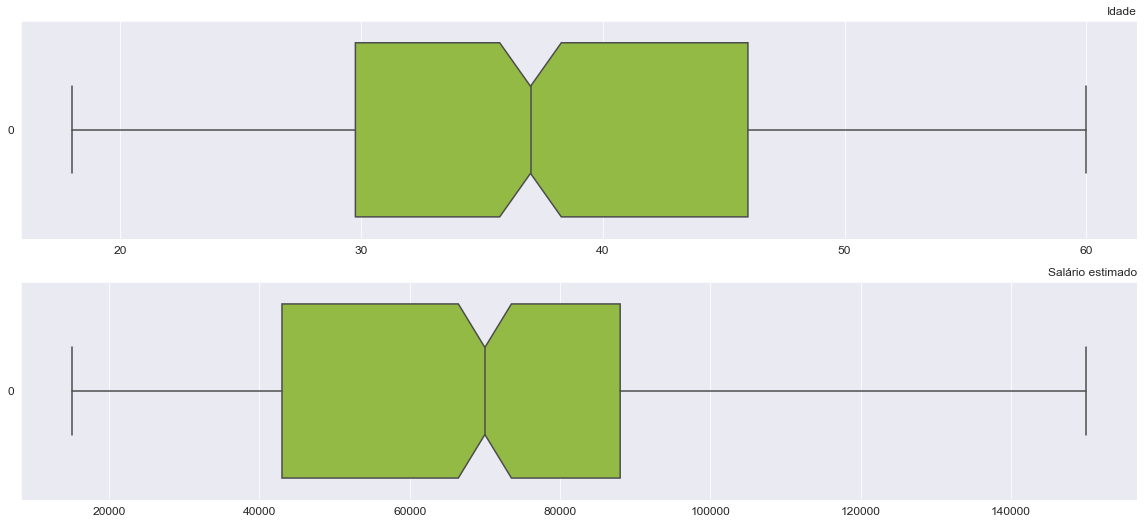

In [393]:
# Função para gerar gráficos boxplot
# param1: coluna do dataframe
# param2: label para gráfico
# param3: axis
# param4: cor, defaut: 'yellowgreen'

def graf_boxplot(param1, param2, param3, param4='yellowgreen'):
    sns.boxplot(data=param1, ax=param3, color=param4, notch=True, orient='h')
    param3.set(xlabel='', ylabel='')
    param3.tick_params(labelsize=12)
    param3.ticklabel_format(style='plain', axis='x')
    param3.set_title(param2, loc='right', fontsize=12)


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 7))

graf_boxplot(df['idade'], 'Idade', ax1)
graf_boxplot(df['salario_estimado'], 'Salário estimado', ax2)

plt.subplots_adjust(top=1.9, bottom=0.95)
plt.show()


In [394]:
# Descrição dos dados estatísticos

df[['idade','salario_estimado']].describe().T


,count,mean,std,min,25%,50%,75%,max
idade,400.0,37.655,10.482877,18.0,29.75,37.0,46.0,60.0
salario_estimado,400.0,69742.500,34096.960282,15000.0,43000.00,70000.0,88000.0,150000.0


## 2. Distribuição dos dados entre as variáveis independentes (features) e dependente (target)


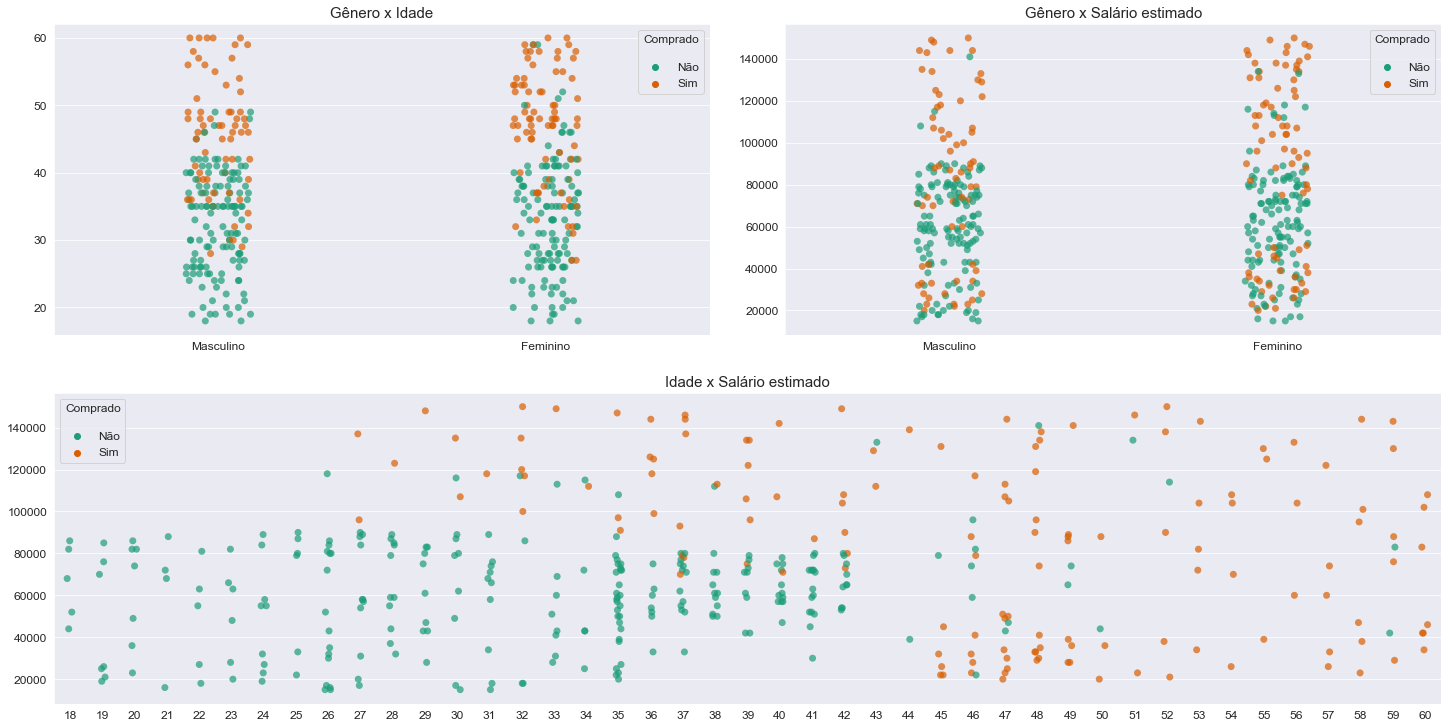

In [329]:
# Função para gerar gráficos stripplot
# param1: nome do dataframe
# param2: variável do eixo X
# param3: variável do eixo Y
# param4: axis
# param5: spec
# param6: label para gráfico
# param7: paleta de cores, default: Dark2

comprado = df['comprado'].replace({1: 'Sim', 0: 'Não'})

def graf_2_stripplot(param1, param2, param3, param4, param5, param6, param7='Dark2'):
    param4 = fig.add_subplot(param5)
    sns.stripplot(data=param1, x=param2, y=param3,
                  ax=param4, hue=comprado, palette=param7, s=7, alpha=0.7)
    param4.set(xlabel='', ylabel='')
    param4.legend(title='Comprado\n', fontsize=12, title_fontsize=12)
    param4.tick_params(labelsize=12)
    param4.ticklabel_format(style='plain', axis='y')
    param4.set_title(param6, fontsize=15)


fig = plt.figure(figsize=(20, 10), constrained_layout=True)
spec = fig.add_gridspec(2, 2)

ax1 = ax2 = ax3 = None

graf_2_stripplot(df, 'genero', 'idade', ax1, spec[0, 0],
                 'Gênero x Idade')
graf_2_stripplot(df, 'genero', 'salario_estimado', ax2, spec[0, 1],
                 'Gênero x Salário estimado')
graf_2_stripplot(df, 'idade', 'salario_estimado', ax3, spec[1, 0:],
                 '\nIdade x Salário estimado')
plt.show()


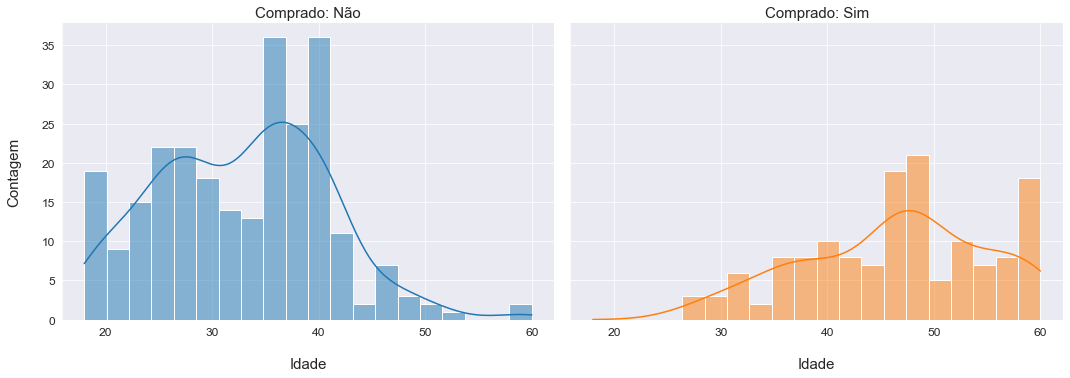

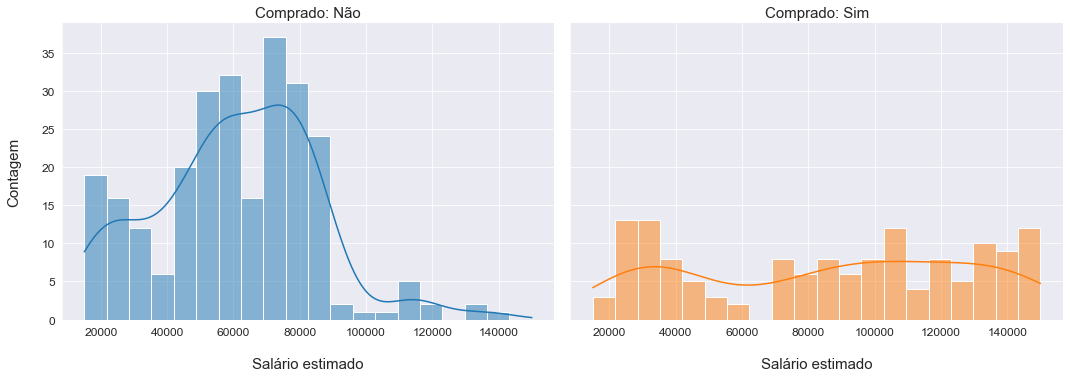

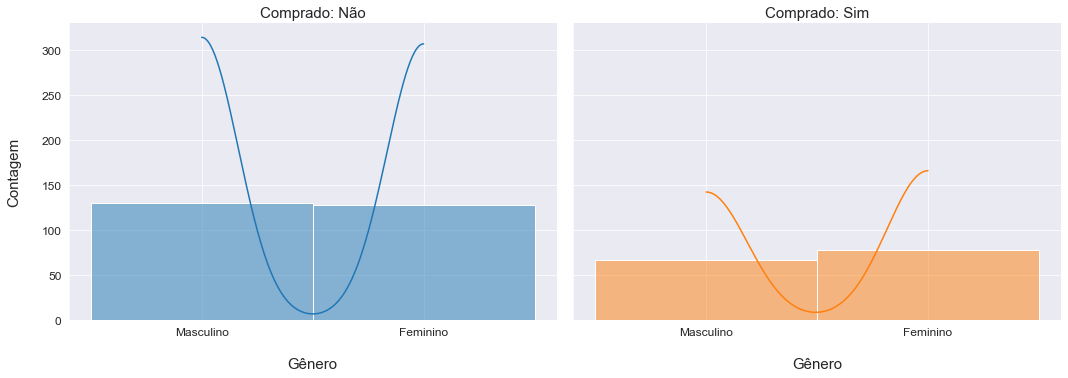

In [382]:
# Função para gerar gráficos displot
# param1: nome do dataframe
# param2: variável do eixo X
# param3: label para gráfico
# param4: cor, default: royalblue

def graf_displot(param1, param2, param3, param4='royalblue'):
    plot = sns.displot(data=param1, x=param2, col=comprado,
                       color=param4, kde=True, bins=20, hue=comprado, legend=False)
    plot.tick_params(labelsize=12)
    plot.set_axis_labels(param3, 'Contagem\n', size=15)
    plot.set_titles('Comprado: {col_name}', size=15)
    plot.figure.set_size_inches(15, 5)

graf_displot(df, 'idade', '\nIdade')
graf_displot(df, 'salario_estimado', '\nSalário estimado')
graf_displot(df, 'genero', '\nGênero')

plt.show()


## 3. Correlação entre as variáveis


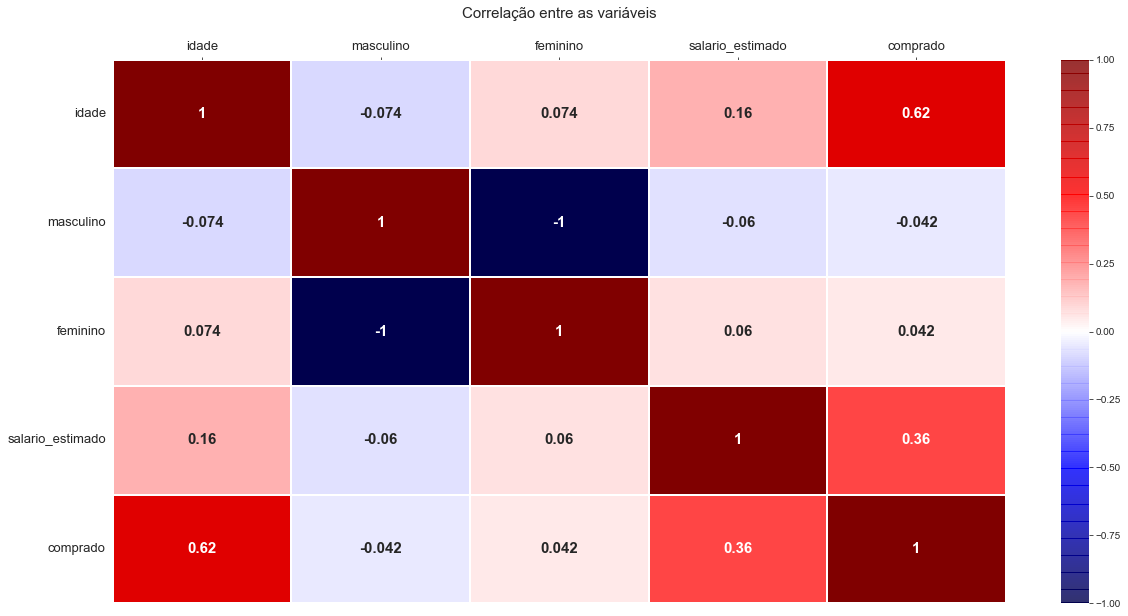

In [332]:

corr = df[['idade', 'masculino', 'feminino', 'salario_estimado', 'comprado',]].corr()


plt.figure(figsize=(20, 10))
plot = sns.heatmap(data=corr,
                annot=True, annot_kws={'size': 15, 'fontweight': 'bold'}, 
                cbar_kws={'extendfrac': .1, 'drawedges': True},
                cmap='seismic', vmin=-1, linewidths=.2,
                xticklabels=['idade', 'masculino', 'feminino', 'salario_estimado', 'comprado'],
                yticklabels=['idade', 'masculino', 'feminino', 'salario_estimado', 'comprado']
                )
plot.set_yticklabels(plot.get_yticklabels(), rotation=0)
plot.set_title('Correlação entre as variáveis\n', loc='center', fontsize=15)
plot.tick_params(labelsize=13)
plot.xaxis.tick_top()
plt.show()


## 4. Criação do modelo de regressão logística


### 1. Separação dos dados de treino e teste


In [333]:

# features, variáveis independentes
X = df.drop(['comprado','genero'], axis=1)

# padronizando os dados das features
std = StandardScaler().fit(X)
X = std.transform(X)

# target, variável dependente
y = df['comprado'].copy()

# definindo o percentual de dados para teste
perc = 0.3

# definindo o random_state
seed = 10

# separação dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=perc, random_state=seed)

print('\nQuantidade de dados divididos em treino e teste')
print('\nX_train:', X_train.shape)
print('y_train:', y_train.shape)
print('\nX_test:', X_test.shape)
print('y_test:', y_test.shape)



Quantidade de dados divididos em treino e teste

X_train: (280, 4)
y_train: (280,)

X_test: (120, 4)
y_test: (120,)


In [335]:
# definição do modelo a ser utilizado nos dados
modelo_rl = LogisticRegression()
print('\nModelo selecionado:', modelo_rl)



Modelo selecionado: LogisticRegression()


### 2. Treinamento do modelo


In [398]:
# treinamento do modelo
modelo_rl.fit(X_train, y_train)

# Acurácia do modelo
print('\nAcurácia do modelo com dados de treino:', accuracy_score(y, modelo_rl.predict(X)) * 100)
print('\nAcurácia do modelo com dados de teste: ', accuracy_score(y_test, modelo_rl.predict(X_test)) * 100)
print('\nAcurácia do modelo com dados de treino:', accuracy_score(y_train, modelo_rl.predict(X_train)) * 100)


Acurácia do modelo com dados de treino: 85.0

Acurácia do modelo com dados de teste:  87.5

Acurácia do modelo com dados de treino: 83.92857142857143


In [337]:
print(classification_report(y, modelo_rl.predict(X)))

#confusion_matrix(y, model.predict(X))

acuracia = accuracy_score(y, modelo_rl.predict(X))
print('O modelo obteve %0.4f de acurácia.' % acuracia)

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       257
           1       0.83      0.73      0.78       143

    accuracy                           0.85       400
   macro avg       0.84      0.82      0.83       400
weighted avg       0.85      0.85      0.85       400

O modelo obteve 0.8500 de acurácia.


### 3. Predições do modelo com dados de teste


In [338]:
# predição com dados de treino
pred_train = modelo_rl.predict(X_train)

# predição com dados de teste
pred_test = modelo_rl.predict(X_test)

pred_test


array([0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1], dtype=int64)

### 4. Resíduo, diferença entre dados de teste e dados previstos


In [339]:
print('\nAmostra das 10 primeiras linhas\n')

residuo = y_test - pred_test

df_comparativo = pd.DataFrame({
    "Dados de teste": y_test,
    "Dados previstos": pred_test,
    "Resíduo": residuo,
})

#df_comparativo.head(10).sort_index()
df_comparativo



Amostra das 10 primeiras linhas



,Dados de teste,Dados previstos,Resíduo
332,0,0,0
111,0,0,0
352,1,1,0
205,0,1,-1
56,0,0,0
...,...,...,...
17,1,0,1
225,0,0,0
223,1,1,0
59,0,0,0


In [340]:
print('\nMédia do resíduo:', residuo.mean())
print('\nDesvio padrão do resíduo:', residuo.std())


Média do resíduo: -0.008333333333333333

Desvio padrão do resíduo: 0.35493716649128576


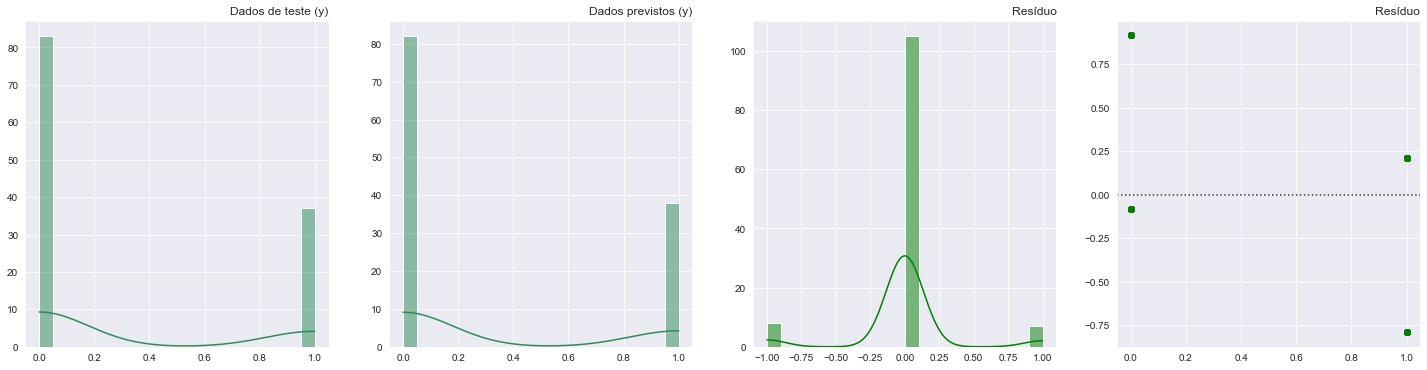

In [341]:
# Função para gerar gráficos histplot
# param1: conjunto de dados
# param2: número de bins
# param3: axis
# param4: label para gráfico
# param5: cor, default: seagreen

def graf_3_histplot(param1, param2, param3, param4, param5='seagreen'):
    sns.histplot(data=param1, bins=param2, ax=param3, color=param5, kde=True)
    param3.set(xlabel='', ylabel='')
    param3.tick_params(labelsize=10)
    param3.ticklabel_format(style='plain', axis='y')
    param3.set_title(param4, loc='right', fontsize=12)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows=1, ncols=4, figsize=(25, 6))

graf_3_histplot(y_test, 20, ax1, 'Dados de teste (y)')
graf_3_histplot(pred_test, 20, ax2, 'Dados previstos (y)')
graf_3_histplot(residuo, 20, ax3, 'Resíduo', 'green')

sns.residplot(y=residuo, x=pred_test, color='green', ax=ax4)
ax4.set(xlabel='', ylabel='')
ax4.tick_params(labelsize=10)
ax4.ticklabel_format(style='plain', axis='y')
ax4.set_title('Resíduo', loc='right', fontsize=12)

plt.show()


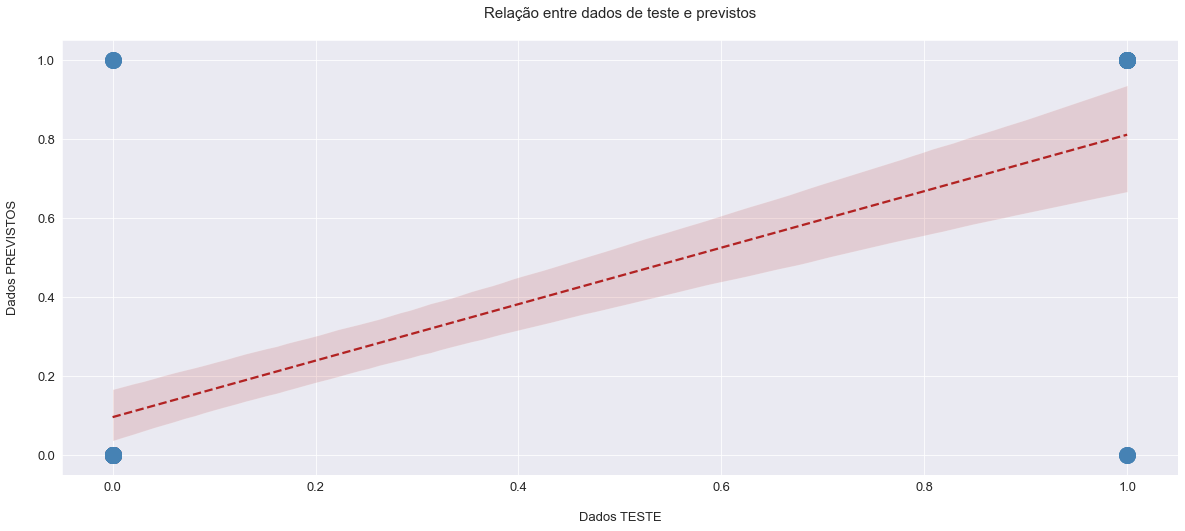

In [342]:
plt.figure(figsize=(20, 8))
plot = sns.regplot(x=y_test, y=pred_test, scatter_kws={
                   'color': 'steelblue', 's': 250, 'alpha': .5}, line_kws={'color': 'firebrick', 'linestyle': 'dashed'})
plot.set_ylabel('Dados PREVISTOS\n', fontsize=13)
plot.set_xlabel('\nDados TESTE', fontsize=13)
plot.ticklabel_format(style='plain', axis='x')
plot.tick_params(labelsize=13)
plot.set_title('Relação entre dados de teste e previstos\n',
               loc='center', fontsize=15)
plt.show()


### 5. Métricas de performance


In [343]:
# definindo os valores dos hiperparâmetros

# definindo o número de folds, número de divisões dos dados
numero_folds = 5

# definindo o random_state
seed = 5

# separando os dados em folds
kfold = KFold(n_splits=numero_folds, shuffle=True, random_state=seed)

# array de score de cada fold
resultado = cross_val_score(modelo_rl, X, y, cv=kfold)

print('\nMétrica do modelo utilizando Cross Validation')
print('\nScore de cada fold:', resultado * 100)
print('\nScore (média):', resultado.mean() * 100)


Métrica do modelo utilizando Cross Validation

Score de cada fold: [86.25 82.5  86.25 83.75 83.75]

Score (média): 84.5


In [344]:
# Função para gerar metricas do modelo
# param1: dados da variável dependente, target
# param2: dados de predição


def metricas(param1, param2):
    arr = []
    # R-Quadrado, ou Coeficiente de Determinação (R2)
    arr.append(r2_score(param1, param2) * 100)
    # Erro Quadrático Médio (MSE)
    arr.append(mean_squared_error(param1, param2))
    # Raiz do erro quadrático médio (RMSE)
    arr.append(mean_squared_error(param1, param2, squared=False))
    # Erro Absoluto Médio (MAE)
    arr.append(mean_absolute_error(param1, param2))
    # Erro Percentual Absoluto Médio (MAPE)
    arr.append(mean_absolute_percentage_error(param1, param2) * 100)
    # Raiz do erro médio quadrático e logarítmico (RMSLE)
    arr.append(mean_squared_log_error(param1, param2))
    return arr


data = {
    '': ['R^2', 'MSE', 'RMSE', 'MAE', 'MAPE', 'RMSLE'],
    'TREINO': [i for i in metricas(y_train, pred_train)],
    'TESTE': [i for i in metricas(y_test, pred_test)],
}

print(tabulate(data, headers='keys', tablefmt='fancy_grid',
               floatfmt=('', '.8f', '.8f')))


╒═══════╤════════════════════════════╤════════════════════════════╕
│       │                     TREINO │                      TESTE │
╞═══════╪════════════════════════════╪════════════════════════════╡
│ R^2   │                31.68510085 │                41.38717030 │
├───────┼────────────────────────────┼────────────────────────────┤
│ MSE   │                 0.16071429 │                 0.12500000 │
├───────┼────────────────────────────┼────────────────────────────┤
│ RMSE  │                 0.40089186 │                 0.35355339 │
├───────┼────────────────────────────┼────────────────────────────┤
│ MAE   │                 0.16071429 │                 0.12500000 │
├───────┼────────────────────────────┼────────────────────────────┤
│ MAPE  │ 22517998136852492.00000000 │ 30023997515803312.00000000 │
├───────┼────────────────────────────┼────────────────────────────┤
│ RMSLE │                 0.07721566 │                 0.06005663 │
╘═══════╧════════════════════════════╧══════════

### 6. Previsões com novos dados


In [345]:
# Função para testar o modelo com novos dados
# param1: quantidade de entradas de novos dados

def teste_modelo(param1):
    arrx = []
    for i in range(param1):
        genero = np.random.randint(0, 2)
        idade = np.random.randint(
            df['idade'].min(), df['idade'].max())
        salario_anual = np.random.randint(
            df['salario_anual'].min(), df['salario_anual'].max())
        divida_cartao_credito = np.random.randint(
            df['divida_cartao_credito'].min(), df['divida_cartao_credito'].max())
        patrimonio_liquido = np.random.randint(
            df['patrimonio_liquido'].min(), df['patrimonio_liquido'].max())

        arr = np.array([genero, idade, salario_anual,
                        divida_cartao_credito, patrimonio_liquido])
        arr = arr.reshape(1, -1)
        arr = np.append(arr, modelo_rl.predict(arr))
        arr = arr.reshape(1, -1)
        arrt = arr.T

        arrx.append(arrt)

    print(tabulate(arrx, headers=['genero', 'idade', 'salario_anual', 
                        'divida_cartao_credito', 'patrimonio_liquido', 
                        'valor_compra_carro\nPrevisão do modelo'], 
                    tablefmt='fancy_grid',
                    floatfmt=('.0f', '.0f', '.2f', '.2f', '.2f', '.5f')))


teste_modelo(5)


KeyError: 'salario_anual'